## Contradictory, My Dear Watson

### Load Data

In [2]:
!pip install sentencepiece


[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import sentencepiece
import tensorflow as tf
from transformers import XLMRobertaTokenizer, BertTokenizer, TFBertModel, TFXLMRobertaModel

E0000 00:00:1719985192.283918    1383 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="localhost"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0703 05:39:52.292261334    1383 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0703 05:39:52.292276279    1383 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0703 05:39:52.292279622    1383 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0703 05:39:52.292281991    1383 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0703 05:39:52.292284308    1383 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [5]:
df_train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
df_test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


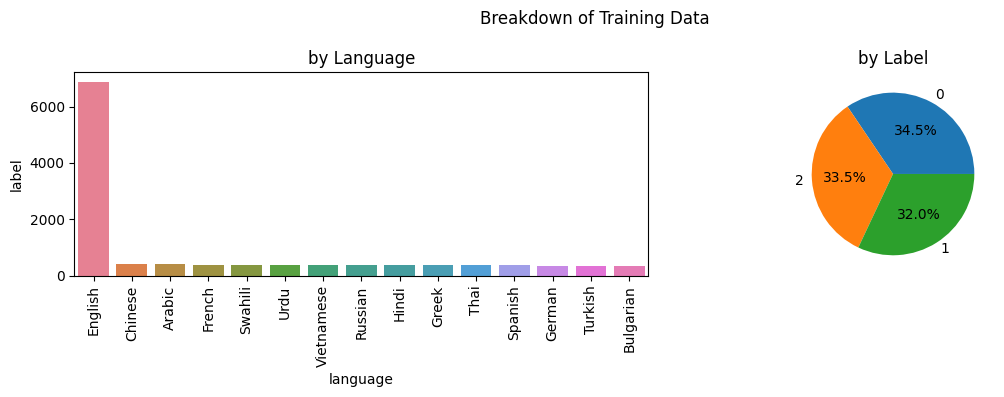

In [6]:
fig, axs = plt.subplots(figsize= (12,4), ncols= 2, nrows= 1)

dt_language = df_train.groupby("language")['label'].count().sort_values(ascending= False).reset_index()
# dt_language.loc[dt_language.label < (0.03*df_train.shape[0]), "language"] = "Other"
# dt_language = dt_language.groupby("language")['label'].sum().sort_values(ascending= False).reset_index()
sns.barplot(data= dt_language, x= "language", y= "label", hue= "language", ax= axs[0])
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)
axs[0].set_title("by Language")

axs[1].pie(df_train["label"].value_counts(), autopct='%1.1f%%', labels= df_train["label"].value_counts().index);
axs[1].set_title("by Label")

plt.suptitle("Breakdown of Training Data");
plt.tight_layout();

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')

In [8]:
# setting up a TPU
# TODO: connect to a cloud TPU later. Currently, generates error and uses CPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

I0000 00:00:1719985200.616685    1383 service.cc:145] XLA service 0x5cde33224340 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719985200.616746    1383 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1719985200.616751    1383 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1719985200.616754    1383 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1719985200.616757    1383 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1719985200.616760    1383 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1719985200.616763    1383 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1719985200.616765    1383 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1719985200.616775    1383 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


In [16]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
# model_name = 'jplu/tf-xlm-roberta-large'
# model_name = 'xlm-roberta-base'
# tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)

In [17]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

encode_sentence("I love machine learning!")

[146, 16138, 21432, 26901, 106, 102]

In [18]:
import numpy as np
max_len= 200
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor()[:,:max_len],
      'input_mask': input_mask[:,:max_len],
      'input_type_ids': input_type_ids[:,:max_len]}

  return inputs

In [19]:
train_input = bert_encode(df_train.premise.values, df_train.hypothesis.values, tokenizer)
test_input = bert_encode(df_test.premise.values, df_test.hypothesis.values, tokenizer)

In [20]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    
    maxpool = tf.keras.layers.GlobalAveragePooling1D(name= 'maxpool')(embedding)
    output = tf.keras.layers.Dense(3, activation='softmax')(maxpool)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
with strategy.scope():
    model = build_model()
    model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 200)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                            

In [22]:
history = model.fit(train_input, df_train.label.values, epochs = 5, verbose = 1, 
                    batch_size = 64, validation_split = 0.2)

Epoch 1/5


2024-07-03 05:43:41.637669: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
I0000 00:00:1719985424.385756    2193 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(192fe1b3557472f0:0:0), session_name()
I0000 00:00:1719985458.118760    2193 tpu_compile_op_common.cc:245] Compilation of 192fe1b3557472f0:0:0 with session name  took 33.732955713s and succeeded
I0000 00:00:1719985458.207868    2193 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(192fe1b3557472f0:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_4411021503695709876", property.function_library_fingerprint = 15431364025911957777, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, 

151/152 [============================>.] - ETA: 0s - loss: 0.9894 - accuracy: 0.4991

I0000 00:00:1719985475.779480    2160 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f2f2cfbf3b936426:0:0), session_name()
I0000 00:00:1719985506.531989    2160 tpu_compile_op_common.cc:245] Compilation of f2f2cfbf3b936426:0:0 with session name  took 30.75246309s and succeeded
I0000 00:00:1719985506.639276    2160 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f2f2cfbf3b936426:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_4411021503695709876", property.function_library_fingerprint = 15431364025911957777, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,200,;4,200,;4,200,;4,;", property.guaranteed_constants_size = 0, embed

152/152 [==============================] - ETA: 0s - loss: 0.9890 - accuracy: 0.4996

2024-07-03 05:45:17.458539: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1719985518.207520    2203 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b942f387164f6dcc:0:0), session_name()
I0000 00:00:1719985522.566822    2203 tpu_compile_op_common.cc:245] Compilation of b942f387164f6dcc:0:0 with session name  took 4.359239818s and succeeded
I0000 00:00:1719985522.598473    2203 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b942f387164f6dcc:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_4722313632901680703", property.function_library_fingerprint = 16797907178058492377, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topolog

152/152 [==============================] - 165s 460ms/step - loss: 0.9890 - accuracy: 0.4996 - val_loss: 0.8578 - val_accuracy: 0.6052
Epoch 2/5


I0000 00:00:1719985527.763293    2162 tpu_compile_op_common.cc:245] Compilation of ffaae1065f88243e:0:0 with session name  took 4.199904729s and succeeded
I0000 00:00:1719985527.786677    2162 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ffaae1065f88243e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_4722313632901680703", property.function_library_fingerprint = 16797907178058492377, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,200,;7,200,;7,200,;7,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1719985527.786715    2162 tpu_compilation_cache_interface.cc:541] After adding entry for key ff

152/152 [==============================] - 19s 125ms/step - loss: 0.7795 - accuracy: 0.6570 - val_loss: 0.8048 - val_accuracy: 0.6407
Epoch 3/5
152/152 [==============================] - 19s 125ms/step - loss: 0.6298 - accuracy: 0.7417 - val_loss: 0.8737 - val_accuracy: 0.6440
Epoch 4/5
152/152 [==============================] - 19s 125ms/step - loss: 0.4709 - accuracy: 0.8122 - val_loss: 1.0659 - val_accuracy: 0.6382
Epoch 5/5
152/152 [==============================] - 19s 125ms/step - loss: 0.3307 - accuracy: 0.8717 - val_loss: 1.1726 - val_accuracy: 0.6419


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


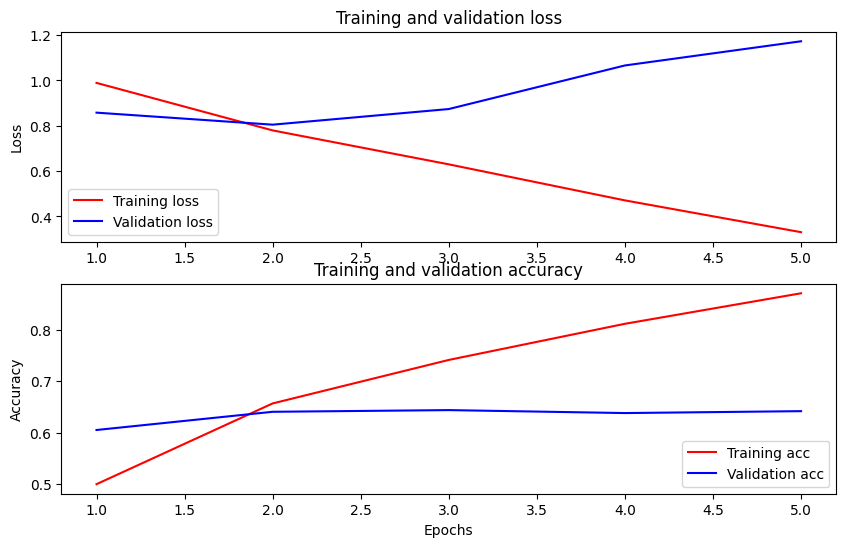

In [23]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [24]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
df_test['pred_label'] = predictions
df_test.head()

2024-07-03 05:46:56.037593: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
I0000 00:00:1719985616.740774    2140 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2c4f19ad0859ad36:0:0), session_name()


  7/163 [>.............................] - ETA: 3s 

I0000 00:00:1719985620.860446    2140 tpu_compile_op_common.cc:245] Compilation of 2c4f19ad0859ad36:0:0 with session name  took 4.119619968s and succeeded
I0000 00:00:1719985620.882144    2140 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2c4f19ad0859ad36:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_16560828902356933129", property.function_library_fingerprint = 1505223769794744916, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,200,;4,200,;4,200,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1719985620.882185    2140 tpu_compilation_cache_interface.cc:541] After adding entry for key 2c

162/163 [============================>.] - ETA: 0s

I0000 00:00:1719985624.030199    2174 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(acdec6ac67216f59:0:0), session_name()


163/163 [==============================] - 23s 42ms/step


I0000 00:00:1719985627.591728    2174 tpu_compile_op_common.cc:245] Compilation of acdec6ac67216f59:0:0 with session name  took 3.56149227s and succeeded
I0000 00:00:1719985627.617739    2174 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(acdec6ac67216f59:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_16560828902356933129", property.function_library_fingerprint = 1505223769794744916, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,200,;2,200,;2,200,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1719985627.617768    2174 tpu_compilation_cache_interface.cc:541] After adding entry for key acd

,id,premise,hypothesis,lang_abv,language,pred_label
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu,2
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic,1
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French,0
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese,1
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian,2


In [25]:
submission = df_test.id.copy().to_frame()
submission['prediction'] = predictions
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2


In [26]:
submission.to_csv("submission.csv", index = False)